# Seed Level on Donation Amount in Kitabisa Website : General View Analysis

This workbook is the part of a bigger research: Seed level on Donation Amount in Kitabisa Website. In this notebook, I am going to analyze the all the donation that is listed in Kitabisa donation page. All of the donations was scraped once in a week for 3 months duration.


In [65]:
import pandas as pd
import numpy as np
import glob
import os
import scipy
import warnings
from datetime import date, datetime, time, timedelta

import matplotlib.pyplot as plt
from matplotlib.pyplot import title
import seaborn as sns

## Reading and Cleaning Data

In [66]:
path = '/Users/mac/Documents/RU/THESIS/working_thesis/pilot_data_2/donation_routine/22_10_03/donation_list_with_prop_2022-10-03 23:15:18_.csv'
df_don = pd.read_csv(path)
df_don.head(3)

,id,title,permalink,short_url,short_description,description,plain_description,image,youtube_video_id,is_forever_runing,...,parent_campaign.is_verified,campaign_medical_detail.beneficiary_name,campaign_medical_detail.diagnosis,campaign_medical_detail.is_hospitalized,campaign_medical_detail.treatment,campaign_medical_detail.budget_allocation_plan,remaining_balance.total,remaining_balance.is_whitelist_campaign,time_scraped,parent_campaign.verification_badge
0,376175,Pneumonia Hingga Cairan Lambung Renggut Senyumnya,https://kitabisa.com/bantuhaminullahberjuang,bantuhaminullahberjuang,"#OrangBaik, Syarifudin sedang berusaha semaksi...","<a href=""https://kitabisa.zendesk.com/hc/en-us...",Ketika bayi berusia 8 bulan lainnya sedang bel...,https://img.kitabisa.cc/size/664x357/aa1b28fb-...,NaN,False,...,False,Muhammad Haminullah,pneumonia KDK Susp Epilepsis,1,"Sudah dibawa kebidan dan Puskesmas, sekarang s...","A. Biaya Rumah Sakit \t\tRp60,000,000\t\r\nB. ...",0,False,2022-10-03 22:18:13,NaN
1,369507,"Sakit Langka, Tulang Bayi 2 Bln Rawan Patah",https://kitabisa.com/bkksbantuahmad,bkksbantuahmad,Penghasilan pak Anhar sebagai buruh bangunan &...,"<a href=""https://kitabisa.zendesk.com/hc/en-us...",“Saya nggak tega liat Ahmad nangis terus. Peng...,https://img.kitabisa.cc/size/664x357/3e6e568c-...,NaN,False,...,False,Ahmad Try Nadhif Anhar,Osteogenesis imperfecta,0,Telah menjalani serangkaian perawatan medis d...,"1. Biaya operasional Rp 30.000.000,-\r\n2. Bia...",0,False,2022-10-03 22:18:19,NaN
2,367402,Bocah 7 Tahun Berjuang Lawan 3 Penyakit Sekali...,https://kitabisa.com/bantusikecilarkanmelawanp...,bantusikecilarkanmelawanpenyakitnya,Si kecil Arkan tengah berjuang melawan 3 penya...,"<p></p>\r\n<a href=""https://kitabisa.zendesk.c...","“Pengobatan Arkan masih panjang, tapi kami uda...",https://img.kitabisa.cc/size/664x357/d6cffb5f-...,NaN,False,...,False,Ahmad Arkan,Tetanus,1,Berbagai pengobatan sudah dilajani oleh keluar...,"Biaya membeli Vitamin Rp.20.000.000, Biaya Raw...",0,False,2022-10-03 22:18:23,NaN


After reading, I transform some of the data to make it more meaningful:

- Giving order for every campaign on the page
- Convert epoch to UTC for starting date of campaign
- Aggregating days running and remaining
- Filtering column needed for the analysis

In [67]:
def etl_df_don(df):
       df = df
       
       # Giving the order for every donation on the page
       df.reset_index(inplace=True)
       df = df.rename(columns = {'index': 'order'})
       df['order'] = df['order'] + 1 
       
       # Convert epoch to UTC, and aggreagating days running and remaining
       df = df.rename(columns={'campaign_start': 'start_ts_unix'})  
       df['start_ts_utc'] = pd.to_datetime(df['start_ts_unix'], unit='s')
       df['days_duration'] = df['days_running'] + df['days_remaining']
       
       # Filtering column needed for the analysis
       col_take = ['order', 'id', 'short_url', 'is_forever_runing', 'is_open_goal',
                   'donation_received', 'donation_count', 'donation_target', 'donation_percentage', 
                   'start_ts_utc', 'days_running', 'days_remaining', 'days_duration', 'is_zakat', 'is_instant_zakat',
                   'is_open_for_donation', 'is_verified', 'is_optimized_by_ads', 'status.description.en', 
                   'campaigner.id', 'campaigner.name', 'campaigner.is_verified', 'campaigner.type',
                   'category.name', 'time_scraped']
       df = df[col_take]
       
       return df

df_don = etl_df_don(df_don)
df_don.head(5)

,order,id,short_url,is_forever_runing,is_open_goal,donation_received,donation_count,donation_target,donation_percentage,start_ts_utc,...,is_open_for_donation,is_verified,is_optimized_by_ads,status.description.en,campaigner.id,campaigner.name,campaigner.is_verified,campaigner.type,category.name,time_scraped
0,1,376175,bantuhaminullahberjuang,False,False,344501406,12726,396610000,0.868615,2022-07-06 08:40:03,...,True,True,True,Proyek sedang berjalan,832449,Amal Bakti Dunia Islam,True,ORGANIZATION,Balita & Anak Sakit,2022-10-03 22:18:13
1,2,369507,bkksbantuahmad,False,False,274507469,14750,233300000,1.176629,2022-05-30 12:33:48,...,True,True,True,Proyek sedang berjalan,5900028,LEMBAGA KEMANUSIAAN TIM AMAL BKKS,True,ORGANIZATION,Bantuan Medis & Kesehatan,2022-10-03 22:18:19
2,3,367402,bantusikecilarkanmelawanpenyakitnya,False,False,300306751,13027,606580000,0.495082,2022-05-18 01:42:08,...,True,True,True,Proyek sedang berjalan,16143,LAZ DASI NTB,True,ORGANIZATION,Balita & Anak Sakit,2022-10-03 22:18:23
3,4,367118,bantuaisyahmelawanjantungbocor,False,False,56491909,3668,115000000,0.491234,2022-05-16 08:58:45,...,True,True,True,Proyek sedang berjalan,6723207,Yayasan Daarul Mukhtar,True,ORGANIZATION,Bantuan Medis & Kesehatan,2022-10-03 22:18:26
4,5,320540,selamatkanadikmaurin,False,False,1574468443,43455,2932500000,0.536896,2021-10-06 08:37:46,...,True,True,True,Proyek sedang berjalan,3564157,Yayasan Rumah Peduli Annisa,True,ORGANIZATION,Balita & Anak Sakit,2022-10-03 22:18:30


After it's done, the final is to finalize and check all the data. From duplicated record, data type, value in every column, and null/missing value.

In [43]:
# Checking duplicated data by short_url colum
df_don[df_don['short_url'].duplicated()]

,order,id,short_url,is_forever_runing,is_open_goal,donation_received,donation_count,donation_target,donation_percentage,campaign_start,...,is_open_for_donation,is_verified,is_optimized_by_ads,status.description.en,campaigner.id,campaigner.name,campaigner.is_verified,campaigner.type,category.name,time_scraped


In [35]:
# Checking the data type in all columns
df_don.dtypes

order                       int64
id                          int64
short_url                  object
is_forever_runing            bool
is_open_goal                 bool
donation_received           int64
donation_count              int64
donation_target             int64
donation_percentage       float64
campaign_start              int64
days_running                int64
days_remaining              int64
is_zakat                     bool
is_instant_zakat             bool
is_open_for_donation         bool
is_verified                  bool
is_optimized_by_ads          bool
status.description.en      object
campaigner.id               int64
campaigner.name            object
campaigner.is_verified       bool
campaigner.type            object
category.name              object
time_scraped               object
dtype: object

In [36]:
# Counting the unique value in every column
df_don.nunique()

order                     1233
id                        1233
short_url                 1233
is_forever_runing            2
is_open_goal                 2
donation_received         1215
donation_count             967
donation_target            420
donation_percentage       1230
campaign_start            1233
days_running               608
days_remaining             247
is_zakat                     2
is_instant_zakat             2
is_open_for_donation         2
is_verified                  2
is_optimized_by_ads          2
status.description.en        2
campaigner.id              771
campaigner.name            766
campaigner.is_verified       2
campaigner.type              3
category.name               18
time_scraped              1233
dtype: int64

In [38]:
# Counting the null value in the data
df_don.isna().sum()

order                     0
id                        0
short_url                 0
is_forever_runing         0
is_open_goal              0
donation_received         0
donation_count            0
donation_target           0
donation_percentage       0
campaign_start            0
days_running              0
days_remaining            0
is_zakat                  0
is_instant_zakat          0
is_open_for_donation      0
is_verified               0
is_optimized_by_ads       0
status.description.en     0
campaigner.id             0
campaigner.name           0
campaigner.is_verified    0
campaigner.type           0
category.name             0
time_scraped              0
dtype: int64

## Routine Filtering

Code below is used to filter campaigns the with some criterias:

- Exceed 90% donation percentage
- Not an open goal 
- Not running forever

 If the campaign meets all the criterias, I will start to scrape the donors list. It will be used later for the main analysis of this study (please refer to **data_analysis.ipynb**).

In [153]:
def routine_filtering(df):
    df = df
    
    # Filtering the data with the criteria
    col = ['order', 'short_url', 'donation_count', 'donation_percentage', 
           'donation_target', 'days_running', 'days_remaining', 'days_duration', 'category.name']
    df_filter = df[col][(df['donation_percentage'] > 0.9) & 
                        (df['is_open_goal'] == False) &
                        (df['is_forever_runing'] == False)
                        ]
    
    print('There are', len(df_filter), 'donations that meet criteria.')
    return df_filter
    
df_filter = routine_filtering(df_don)
df_filter

There are 46 donations that meet criteria.


,order,short_url,donation_count,donation_percentage,donation_target,days_running,days_remaining,days_duration,category.name
1,2,bkksbantuahmad,14750,1.176629,233300000,126,28,154,Bantuan Medis & Kesehatan
5,6,bantumamameity,5327,0.920999,151645000,88,99,187,Bantuan Medis & Kesehatan
26,27,operasibayiojol,17256,1.111136,270500000,62,58,120,Balita & Anak Sakit
30,31,ymkabantuanakpenjualsiomay,8562,0.946712,193423414,237,28,265,Balita & Anak Sakit
31,32,bantuanlawankankerganaskakakku,2726,0.940650,230000000,108,11,119,Bantuan Medis & Kesehatan
35,36,istiqlalpalestina,110908,0.981172,4500000000,1397,58,1455,Rumah Ibadah
40,41,wakafmushafalquran,58001,1.002680,1500000000,1826,70,1896,Bantuan Pendidikan
42,43,yukinfaqyatim,40027,0.919403,700000000,236,1154,1390,Bencana Alam
44,45,zakatuntukyatimdhuafa,241776,0.998762,6000000000,623,120,743,Zakat
63,64,zakatfakirmiskinsantriyatimdhufa,19064,1.004379,250000000,105,120,225,Zakat


## Exploratory Data Analysis

### Descriptive Analysis : Pooled Data

In [72]:
def desc_quant_table():
    quant_col = ['donation_received', 'donation_count', 'donation_target',
                 'donation_percentage', 'days_running', 'days_remaining', 'days_duration']
    display(df_don[quant_col].describe())

desc_quant_table()

,donation_received,donation_count,donation_target,donation_percentage,days_running,days_remaining,days_duration
count,1.233000e+03,1233.000000,1.233000e+03,1233.000000,1233.000000,1233.000000,1233.000000
mean,3.194460e+08,10337.735604,1.166003e+11,0.275928,467.678832,202.926196,670.605028
std,1.954835e+09,31825.701934,5.250189e+11,0.322981,579.263351,584.690369,872.018411
min,1.000000e+03,1.000000,2.500000e+07,0.000001,1.000000,0.000000,11.000000
25%,4.269565e+06,114.000000,1.750000e+08,0.009138,72.000000,28.000000,120.000000
50%,4.525624e+07,1532.000000,3.000000e+08,0.109260,217.000000,74.000000,308.000000
75%,1.752693e+08,7411.000000,7.000000e+08,0.509724,658.000000,106.000000,830.000000
max,4.142649e+10,421602.000000,2.500000e+12,2.029276,2452.000000,5586.000000,7563.000000


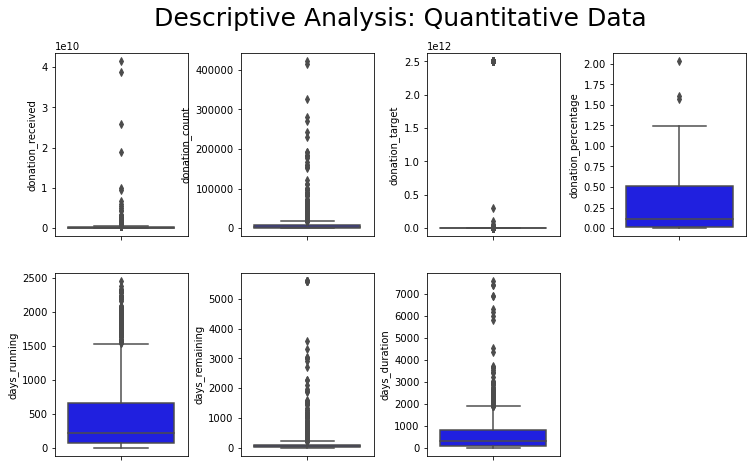

In [75]:
def desc_quant_graph(df):
    df = df
    quant_col = ['donation_received', 'donation_count', 'donation_target',
                 'donation_percentage', 'days_running', 'days_remaining', 'days_duration']
    
    fig = plt.figure(figsize=[12, 8])
    
    i = 1
    for quant in quant_col:
        ax = fig.add_subplot(2, 4, i)  # adjust the size of the subplot based on number of campaigns
        sns.boxplot(y=quant, data=df, orient='v', color='blue')
        # ax.set_xticklabels(bins[:-1])  # turned off to make it much clearer
        i = i + 1
    
    # To set the aesthetic
    fig.suptitle('Descriptive Analysis: Quantitative Data', size=25)    
    plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.2)
     
    plt.show()

desc_quant_graph(df_don)

### Descriptive Analysis : Category Name

/var/folders/6r/bbg64kh96z77l55kblwtwc8r0000gp/T/ipykernel_58227/3346462777.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


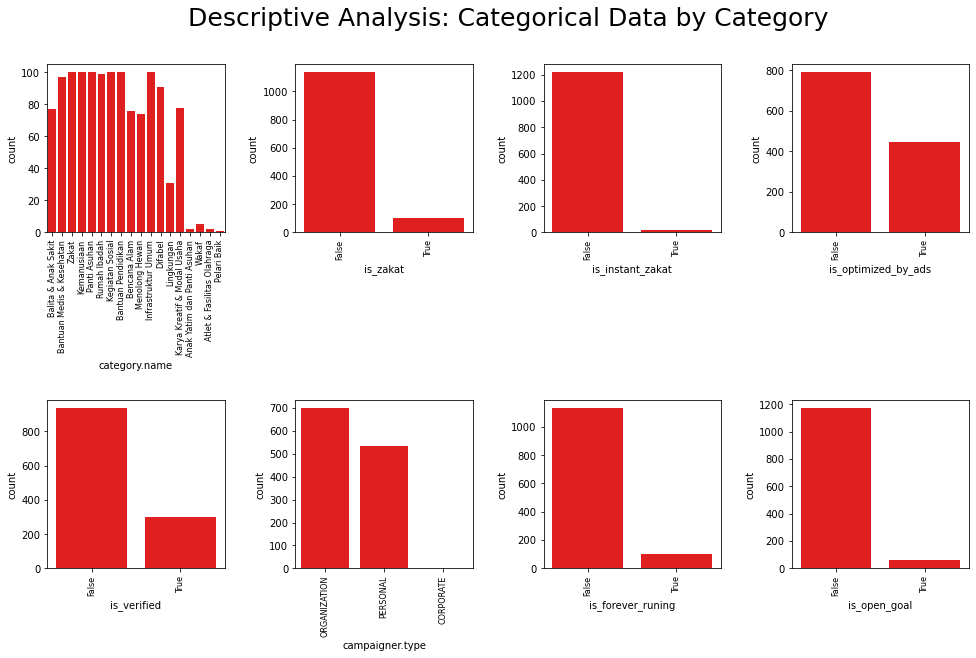

In [150]:
def desc_cat(df):
    df = df
    cat_col = ['category.name', 'is_zakat', 'is_instant_zakat', 'is_optimized_by_ads',
               'is_verified', 'campaigner.type', 'is_forever_runing', 'is_open_goal']

    fig = plt.figure(figsize=[16, 10])
    
    i = 1
    for cat in cat_col:
        ax = fig.add_subplot(2, 4, i)  # adjust the size of the subplot based on number of campaigns
        ax.tick_params(axis='x', labelsize=8, rotation=90)
        sns.countplot(x=cat, data=df, color='red')
        i = i + 1

    # To set the aesthetic
    fig.suptitle('Descriptive Analysis: Categorical Data by Category', size=25)
    plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=1)
    
    fig.show()

desc_cat(df_don)

In [118]:
def desc_quant_by_cat(df):
    df = df
    col = ['category.name', 'donation_percentage']
    df_desc = df[col].groupby('category.name').describe()
    df_desc.sort_values([('donation_percentage', 'mean')], ascending=False, inplace=True)
    display(df_desc)

desc_quant_by_cat(df_don)

donation_percentage                                \
                                          count      mean       std       min   
category.name                                                                   
Balita & Anak Sakit                        77.0  0.539039  0.359063  0.000064   
Kegiatan Sosial                           100.0  0.415243  0.316040  0.000001   
Bantuan Medis & Kesehatan                  97.0  0.382353  0.326570  0.001728   
Kemanusiaan                               100.0  0.336453  0.377716  0.000001   
Anak Yatim dan Panti Asuhan                 2.0  0.324328  0.057499  0.283670   
Lingkungan                                 31.0  0.307737  0.334571  0.000005   
Rumah Ibadah                               99.0  0.295832  0.313366  0.000177   
Panti Asuhan                              100.0  0.288969  0.302404  0.000605   
Bencana Alam                               76.0  0.280936  0.300526  0.000650   
Menolong Hewan                             74.0  0.264410  0.289170  0.000055   
Zakat                                     100.0  0.259878  0.342318  0.000004   
Difabel                                    91.0  0.174948  0.264071  0.000028   
Bantuan Pendidikan                        100.0  0.152650  0.265567  0.000006   
Infrastruktur Umum                        100.0  0.147682  0.243320  0.000003   
Wakaf                                       5.0  0.127392  0.283760  0.000180   
Karya Kreatif & Modal Usaha                78.0  0.058659  0.141285  0.000001   
Atlet & Fasilitas Olahraga                  2.0  0.004354  0.000915  0.003707   
Pelari Baik                                 1.0  0.002299       NaN  0.002299   

                                                                     
                                  25%       50%       75%       max  
category.name                                                        
Balita & Anak Sakit          0.233773  0.562764  0.832886  1.610394  
Kegiatan Sosial              0.112596  0.421598  0.690842  1.232900  
Bantuan Medis & Kesehatan    0.048534  0.353191  0.667005  1.176629  
Kemanusiaan                  0.012518  0.184449  0.632014  2.029276  
Anak Yatim dan Panti Asuhan  0.303999  0.324328  0.344657  0.364986  
Lingkungan                   0.018038  0.160959  0.514837  1.247288  
Rumah Ibadah                 0.015474  0.146227  0.547513  1.017794  
Panti Asuhan                 0.031346  0.166725  0.529430  1.101722  
Bencana Alam                 0.017691  0.168511  0.459014  1.001422  
Menolong Hewan               0.038437  0.129913  0.454756  0.977260  
Zakat                        0.001184  0.068219  0.476179  1.576200  
Difabel                      0.006035  0.028809  0.283384  0.954343  
Bantuan Pendidikan           0.000875  0.014152  0.168852  1.143939  
Infrastruktur Umum           0.000840  0.017624  0.109162  0.817256  
Wakaf                        0.000414  0.000455  0.000911  0.634998  
Karya Kreatif & Modal Usaha  0.000241  0.001567  0.023879  0.768761  
Atlet & Fasilitas Olahraga   0.004031  0.004354  0.004678  0.005002  
Pelari Baik                  0.002299  0.002299  0.002299  0.002299

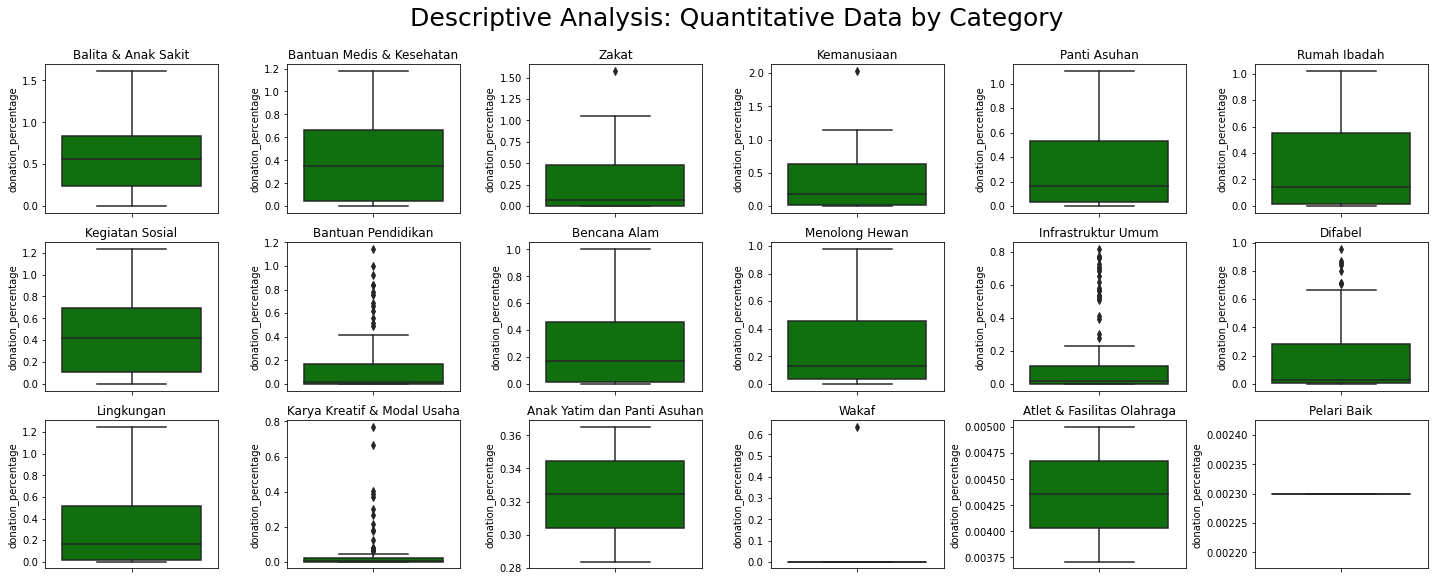

In [151]:
def desc_quant_by_cat(df):
    df = df
    
    fig = plt.figure(figsize=[24, 10])
    
    i = 1
    for cat in df_don['category.name'].unique():
        ax = fig.add_subplot(3, 6, i)  # adjust the size of the subplot based on number of campaigns
        ax.title.set_text(cat)
        sns.boxplot(y='donation_percentage', data=df[df['category.name'] == cat], orient='v', color='green')
        i = i + 1
    
    # To set the aesthetic
    fig.suptitle('Descriptive Analysis: Quantitative Data by Category', size=25)    
    plt.subplots_adjust(left=0.1,
                    bottom=0.2,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.2)
     
    plt.show()

desc_quant_by_cat(df_don)